In [78]:
import os
from copy import deepcopy
from datetime import datetime
from os import listdir
from math import floor


import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

In [2]:
def get_conf(conf_path):
    """Reads configuration file"""
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [3]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = str(round(sum(diff/avg)/len(forecast) * 100, 2))

    print('SMAPE Error Score: ' + smape_score + ' %')
    return smape_score

In [4]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.rcParams["figure.figsize"] = [16,9]
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [5]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [6]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.json'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)

    else:
        sorted_xgb_models = [x for x in listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))


    return xgb_model, dtest

In [7]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=2)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [99]:
def lstm_model_gen(params,lstm_model_dir, train_gen, eval_gen, shape, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=5)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=shape, return_sequences=True))
        model_lstm.add(Dropout(params['LSTM_DROPOUT']))
        model_lstm.add(LSTM(params['LSTM_NODES']//2, activation='relu', input_shape=shape, return_sequences=False))

        model_lstm.add(Dense(params['LSTM_LABEL_COUNT']))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            train_gen,
            validation_data= eval_gen,
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm

In [8]:
def read_data(path, date_index_col):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        return df

In [9]:
# Prepare data by aggregating according to config
def data_preprocessing(data, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()
    data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
    data = data.agg({f'{label_col}':['mean']})
    data.columns = grouped_cols + [label_col]
    return data


In [10]:
def xgboost_data_preprocessing(data_in,date_col):

    data = deepcopy(data_in)
    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek


    return data

In [11]:
def series_to_supervised(data_in, window=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    data = deepcopy(data_in)
    # Drop date column from data
    data.drop('date', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    # Drop rows with different item or store values than the shifted columns

    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    agg = agg[(agg['store(t)'] == agg[last_store])]
    agg = agg[(agg['item(t)'] == agg[last_item])]

    columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    agg.drop(columns_to_drop, axis=1, inplace=True)
    agg.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    print(type(agg))

    return agg


In [12]:
def split_train_valid(data, test_size, lag):

    # Label
    labels_col = 'sales(t+%d)' % lag
    labels = data[labels_col]
    data = data.drop(labels_col, axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, random_state=0)

    return X_train, Y_train, X_valid, Y_valid

In [13]:
def reshape_features(X_train,X_valid):
    X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    return X_train_series, X_valid_series

In [155]:
def data_scaler(data, type=None, scaled=False):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+SCALER_FILE)

        if type=='inverse':
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        fitted_scaler = scaler.fit(data)
        scaled_data = fitted_scaler.transform(data)
        joblib.dump(fitted_scaler, OBJECTS_DIR+SCALER_FILE)
        return scaled_data


In [53]:
def difference_data(data, d, inverse=False, orig=None):

    for i in range(d):
        if not inverse:
            zeroth = data.iloc[0]
            data = data.diff(axis=0)
            return data, zeroth
        else:
            data_ind = data.index
            data = data.reset_index().drop(f'{conf["INDEX_COL"]}', axis=1)
            data.iloc[0] = orig
            for i, r in data.iterrows():
                if i==0:
                    continue
                data.iloc[i] = data.iloc[i] + data.iloc[i-1]
            data.index = data_ind
            return data

In [98]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')
conf = get_conf(CONFIGS_PATH)

SCALER_FILE = 'lstmscaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]

In [16]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0)
test = read_data(TEST_PATH, 1)

<h1> LSTM </h1>

In [56]:
train_pivot = pd.pivot_table(train, index=train.index, values=conf['LABEL_COL'], columns=conf['CATEGORIES'])
train_pivot

item        1                                       ...  50                  \
store       1   2   3   4   5   6   7   8   9   10  ...  1   2   3   4   5    
date                                                ...                       
2013-01-01  13  12  19  10  11  20   7  16  11  14  ...  30  43  45  38  19   
2013-01-02  11  16   8  12   9   6   4  10   9  14  ...  32  57  47  35  25   
2013-01-03  14  16  10   8  12  11   8  12  20  16  ...  25  45  39  32  28   
2013-01-04  13  20  15  15   8   7   7  21  22  17  ...  32  45  48  36  27   
2013-01-05  10  16  22  19  13  12   8  15  22  12  ...  35  55  46  47  31   
...         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
2017-12-27  14  19  16  15  15  14  13  13  16  19  ...  38  79  52  48  35   
2017-12-28  19  21  17  26  13   8  18  25  19  12  ...  52  68  75  58  39   
2017-12-29  15  18  21  28  18  16  18  34  16  23  ...  59  67  68  56  37   
2017-12-30  27  24  31  21  19  10  17  30  31  26  ...  66  79  62  66  60   
2017-12-31  23  31  19  23  24  19  16  26  19  27  ...  45  73  77  81  36   

item                            
store       6   7   8   9   10  
date                            
2013-01-01  20  21  45  36  33  
2013-01-02  23  30  54  44  37  
2013-01-03  38  20  54  29  46  
2013-01-04  33  27  52  43  51  
2013-01-05  33  18  48  53  41  
...         ..  ..  ..  ..  ..  
2017-12-27  47  33  64  52  63  
2017-12-28  49  41  73  73  59  
2017-12-29  43  44  80  68  74  
2017-12-30  41  44  70  62  62  
2017-12-31  45  46  76  65  82  

[1826 rows x 500 columns]

In [ ]:
# Difference data to remove trend
diff_train_pivot, train_orig = difference_data(train_pivot,1)
diff_train_pivot

In [55]:
undiff_train_pivot = difference_data(diff_train_pivot,1,inverse=True, orig=train_orig)
undiff_train_pivot

C:\Users\yashc\AppData\Local\Temp\ipykernel_21708\3689917374.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = data.reset_index().drop(f'{conf["INDEX_COL"]}', axis=1)


item          1                                                         ...  \
store         1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2013-01-01  13.0  12.0  19.0  10.0  11.0  20.0   7.0  16.0  11.0  14.0  ...   
2013-01-02  11.0  16.0   8.0  12.0   9.0   6.0   4.0  10.0   9.0  14.0  ...   
2013-01-03  14.0  16.0  10.0   8.0  12.0  11.0   8.0  12.0  20.0  16.0  ...   
2013-01-04  13.0  20.0  15.0  15.0   8.0   7.0   7.0  21.0  22.0  17.0  ...   
2013-01-05  10.0  16.0  22.0  19.0  13.0  12.0   8.0  15.0  22.0  12.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2017-12-27  14.0  19.0  16.0  15.0  15.0  14.0  13.0  13.0  16.0  19.0  ...   
2017-12-28  19.0  21.0  17.0  26.0  13.0   8.0  18.0  25.0  19.0  12.0  ...   
2017-12-29  15.0  18.0  21.0  28.0  18.0  16.0  18.0  34.0  16.0  23.0  ...   
2017-12-30  27.0  24.0  31.0  21.0  19.0  10.0  17.0  30.0  31.0  26.0  ...   
2017-12-31  23.0  31.0  19.0  23.0  24.0  19.0  16.0  26.0  19.0  27.0  ...   

item          50                                                        
store         1     2     3     4     5     6     7     8     9     10  
date                                                                    
2013-01-01  30.0  43.0  45.0  38.0  19.0  20.0  21.0  45.0  36.0  33.0  
2013-01-02  32.0  57.0  47.0  35.0  25.0  23.0  30.0  54.0  44.0  37.0  
2013-01-03  25.0  45.0  39.0  32.0  28.0  38.0  20.0  54.0  29.0  46.0  
2013-01-04  32.0  45.0  48.0  36.0  27.0  33.0  27.0  52.0  43.0  51.0  
2013-01-05  35.0  55.0  46.0  47.0  31.0  33.0  18.0  48.0  53.0  41.0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2017-12-27  38.0  79.0  52.0  48.0  35.0  47.0  33.0  64.0  52.0  63.0  
2017-12-28  52.0  68.0  75.0  58.0  39.0  49.0  41.0  73.0  73.0  59.0  
2017-12-29  59.0  67.0  68.0  56.0  37.0  43.0  44.0  80.0  68.0  74.0  
2017-12-30  66.0  79.0  62.0  66.0  60.0  41.0  44.0  70.0  62.0  62.0  
2017-12-31  45.0  73.0  77.0  81.0  36.0  45.0  46.0  76.0  65.0  82.0  

[1826 rows x 500 columns]

In [25]:
test_pivot = pd.pivot_table(test, index=test.index, values='id', columns=conf['CATEGORIES'])
test_pivot

item        1                                                ...     50  \
store       1    2    3    4    5    6    7    8    9    10  ...     1    
date                                                         ...          
2018-01-01   0   90  180  270  360  450  540  630  720  810  ...  44100   
2018-01-02   1   91  181  271  361  451  541  631  721  811  ...  44101   
2018-01-03   2   92  182  272  362  452  542  632  722  812  ...  44102   
2018-01-04   3   93  183  273  363  453  543  633  723  813  ...  44103   
2018-01-05   4   94  184  274  364  454  544  634  724  814  ...  44104   
...         ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
2018-03-27  85  175  265  355  445  535  625  715  805  895  ...  44185   
2018-03-28  86  176  266  356  446  536  626  716  806  896  ...  44186   
2018-03-29  87  177  267  357  447  537  627  717  807  897  ...  44187   
2018-03-30  88  178  268  358  448  538  628  718  808  898  ...  44188   
2018-03-31  89  179  269  359  449  539  629  719  809  899  ...  44189   

item                                                                       
store          2      3      4      5      6      7      8      9      10  
date                                                                       
2018-01-01  44190  44280  44370  44460  44550  44640  44730  44820  44910  
2018-01-02  44191  44281  44371  44461  44551  44641  44731  44821  44911  
2018-01-03  44192  44282  44372  44462  44552  44642  44732  44822  44912  
2018-01-04  44193  44283  44373  44463  44553  44643  44733  44823  44913  
2018-01-05  44194  44284  44374  44464  44554  44644  44734  44824  44914  
...           ...    ...    ...    ...    ...    ...    ...    ...    ...  
2018-03-27  44275  44365  44455  44545  44635  44725  44815  44905  44995  
2018-03-28  44276  44366  44456  44546  44636  44726  44816  44906  44996  
2018-03-29  44277  44367  44457  44547  44637  44727  44817  44907  44997  
2018-03-30  44278  44368  44458  44548  44638  44728  44818  44908  44998  
2018-03-31  44279  44369  44459  44549  44639  44729  44819  44909  44999  

[90 rows x 500 columns]

In [157]:
diff_train_pivot.values

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ -2.,   4., -11., ...,   9.,   8.,   4.],
       [  3.,   0.,   2., ...,   0., -15.,   9.],
       ...,
       [ -4.,  -3.,   4., ...,   7.,  -5.,  15.],
       [ 12.,   6.,  10., ..., -10.,  -6., -12.],
       [ -4.,   7., -12., ...,   6.,   3.,  20.]])

In [158]:
scaled_diff_train = data_scaler(diff_train_pivot.dropna().values)

In [159]:
train_set = scaled_diff_train[:floor(len(scaled_diff_train)*0.8)]
eval_set = scaled_diff_train[floor(len(scaled_diff_train)*0.8):]

In [160]:
x = scaled_diff_train[:-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']]

y = scaled_diff_train[conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']:]

In [161]:
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.2)




In [162]:
train_generator = TimeseriesGenerator(x_train, y_train, length=30, batch_size=10)
eval_generator = TimeseriesGenerator(x_eval, y_eval, length=30, batch_size=10)

In [163]:
x_train

array([[-0.56545751, -1.17570623, -0.24320088, ..., -1.06890547,
        -0.49204735, -1.73735311],
       [ 1.69327839, -0.1186711 , -0.12160044, ..., -0.32130659,
         1.71777635, -0.34871342],
       [ 1.2697654 ,  1.64305412, -0.48640176, ...,  1.12049126,
         0.42871253, -0.58015337],
       ...,
       [-0.28311553,  0.1162256 , -0.36480132, ..., -0.90870571,
         0.12179257,  1.44494617],
       [-0.56545751, -1.64549962, -0.48640176, ...,  1.01369142,
        -1.53557521, -1.67949312],
       [ 0.98742342, -0.47101614, -0.6080022 , ...,  0.37289237,
         0.49009652, -0.11727348]])

In [164]:
y_train

array([[-1.55365447e+00,  1.52560578e+00,  1.45920527e+00, ...,
         1.01369142e+00,  1.83176559e-01,  9.82066278e-01],
       [-9.88970496e-01,  5.86018991e-01,  1.82400659e+00, ...,
         7.46691816e-01,  1.04255244e+00,  1.09778625e+00],
       [ 1.26976540e+00,  5.86018991e-01,  2.43200879e-01, ...,
         1.59292694e-01, -1.10588727e+00, -3.48713423e-01],
       ...,
       [ 1.12859441e+00,  1.64305412e+00, -1.21600439e-01, ...,
         6.93291896e-01,  5.51480509e-01,  1.09778625e+00],
       [-7.06628509e-01, -3.53567794e-01, -1.70240615e+00, ...,
         5.24928531e-02,  1.47224039e+00,  5.19186382e-01],
       [ 5.63910435e-01, -1.22274993e-03,  4.86401758e-01, ...,
        -4.28106429e-01,  7.97016477e-01, -6.38013358e-01]])

In [165]:
mdl = lstm_model_gen(conf['LSTM_PARAMS'],
                     MODEL_DIR,
                     train_gen=train_generator,
                     eval_gen=eval_generator,
                     shape=(30,500),
                     training_req=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 256)           775168    
                                                                 
 dropout_5 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dense_5 (Dense)             (None, 500)               64500     
                                                                 
Total params: 1,036,788
Trainable params: 1,036,788
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
136/136 [==============================] - 16s 105ms/step - loss: 1.0272 - val_loss: 1.0620
Epoch 2/100
136/136 [==============================] - 13s 99ms/step - l

In [166]:
pred = mdl.predict(eval_generator)

32/32 [==============================] - 1s 16ms/step


In [167]:
invs_pred = data_scaler(pred, type='inverse', scaled=True)
invs_y = data_scaler(y_eval, type='inverse', scaled=True)

In [168]:
lstm_smape = SMAPE(invs_pred[:,400].reshape(-1,1), invs_y[30:,400].reshape(-1,1))

SMAPE Error Score: 194.41 %


In [169]:
invs_pred

array([[0.06749203, 0.0839102 , 0.10378087, ..., 0.05841792, 0.10450073,
        0.32646984],
       [0.05317353, 0.08583217, 0.09768389, ..., 0.07150855, 0.07702912,
        0.34305462],
       [0.0161181 , 0.06552368, 0.12932454, ..., 0.14986995, 0.03382723,
        0.44684964],
       ...,
       [0.05548912, 0.08598567, 0.09641436, ..., 0.0581371 , 0.08073825,
        0.3233952 ],
       [0.02200753, 0.07336355, 0.10976434, ..., 0.11499941, 0.04345456,
        0.37856433],
       [0.02791474, 0.07088254, 0.11650877, ..., 0.11968898, 0.05264666,
        0.3987515 ]], dtype=float32)

In [143]:
y_eval[30:,400]

array([ 2.71320925e-01, -2.45608578e+00, -1.91060444e+00,  1.08954294e+00,
       -1.22875276e+00, -1.36512310e+00, -6.83271423e-01, -8.19641758e-01,
        5.44061596e-01, -1.77423411e+00,  5.44061596e-01, -1.09238243e+00,
        1.63502428e+00,  5.44061596e-01,  5.44061596e-01,  6.80431931e-01,
       -1.36512310e+00,  4.07691260e-01,  1.22591327e+00,  6.80431931e-01,
        6.80431931e-01,  8.16802267e-01,  5.44061596e-01,  1.63502428e+00,
       -6.83271423e-01,  8.16802267e-01,  9.53172602e-01,  1.77139461e+00,
       -6.83271423e-01, -5.46901088e-01, -1.41974596e-03,  1.22591327e+00,
        1.22591327e+00,  2.71320925e-01, -1.50149344e+00, -1.36512310e+00,
       -9.56012094e-01,  1.22591327e+00, -4.10530752e-01,  1.77139461e+00,
        4.07691260e-01,  1.63502428e+00,  1.08954294e+00,  1.34950589e-01,
       -2.74160417e-01, -2.04697478e+00, -9.56012094e-01, -8.19641758e-01,
        2.04413529e+00, -1.36512310e+00, -1.09238243e+00, -1.41974596e-03,
       -9.56012094e-01,  

In [142]:
lstm_smape = SMAPE(pred[:,400].reshape(-1,1), y_eval[30:,400].reshape(-1,1))

SMAPE Error Score: 172.72 %


In [139]:
y_eval[30:,222]

array([ 8.00926169e-01, -3.10921308e+00, -7.02973541e-01, -6.02713560e-01,
       -4.02193599e-01,  2.99626265e-01, -1.01413657e-01, -3.01933618e-01,
        6.00406207e-01, -5.02453580e-01, -1.01413657e-01, -6.02713560e-01,
        1.99366285e-01,  1.90378596e+00, -1.20427344e+00,  1.40248605e+00,
       -5.02453580e-01, -1.15367649e-03,  7.00666188e-01,  1.00144613e+00,
        1.20196609e+00,  1.20196609e+00, -2.01673638e-01,  6.00406207e-01,
       -7.02973541e-01, -7.02973541e-01,  7.00666188e-01,  1.60300601e+00,
       -6.02713560e-01,  1.20196609e+00,  1.99366285e-01,  2.10430592e+00,
       -9.03493502e-01,  9.01186149e-01, -1.15367649e-03, -2.40739321e+00,
        1.70326599e+00, -4.02193599e-01,  5.00146227e-01, -4.02193599e-01,
       -5.02453580e-01, -1.60531337e+00, -1.90609331e+00, -1.01413657e-01,
        2.99626265e-01, -1.20427344e+00,  1.00144613e+00, -1.15367649e-03,
        1.30222607e+00, -1.20427344e+00, -3.01933618e-01, -2.60791317e+00,
       -6.02713560e-01, -

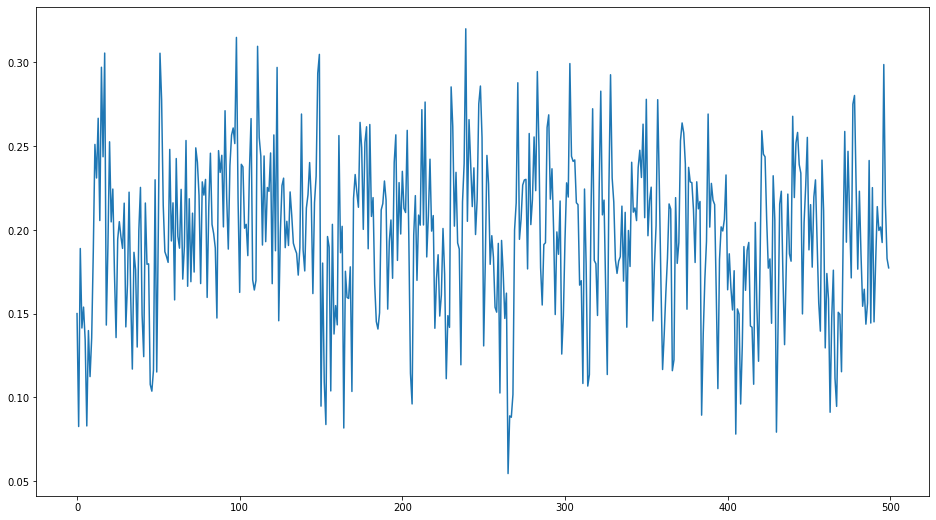

In [132]:
plt.plot(pred[222].reshape(-1,1))

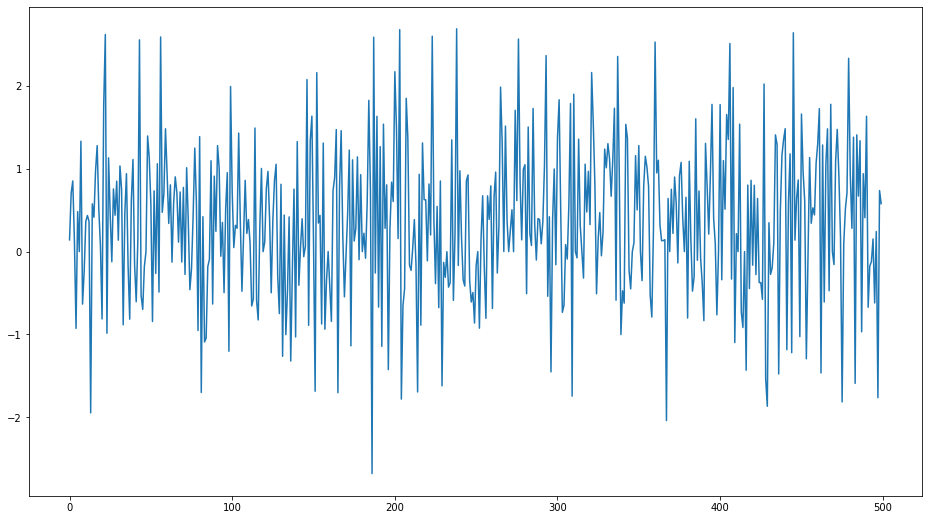

In [135]:
plt.plot(y_eval[222].reshape(-1,1))

----------------------------

In [46]:
# Prepare train data for lstm by aggregating
preprocessed_data = data_preprocessing(train,
                                       conf['GROUPED_COLS'],
                                       conf['LABEL_COL'],
                                       conf['INDEX_COL']
                                       )

In [18]:
# Convert data into format fit for LSTM
lstm_processed_data_2 = series_to_supervised(preprocessed_data,
                                             window=conf['LSTM_PARAMS']['LSTM_WINDOW_LENGTH'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

<class 'pandas.core.frame.DataFrame'>


In [19]:
# Split into train-test set
X_train, Y_train, X_valid, Y_valid = split_train_valid(lstm_processed_data_2,
                                                       test_size=0.2,
                                                       lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                                       )

In [20]:
# Scale data for training
X_train_scaled = data_scaler(X_train, scaled=0, model='lstm')
X_valid_scaled = data_scaler(X_valid, scaled=1, model='lstm')

In [21]:
# Reshape data for training
X_train_series, X_valid_series = reshape_features(X_train, X_valid)

In [22]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        X_train_series,
                        Y_train,
                        X_valid_series,
                        Y_valid,
                        training_req=0
                        )

In [23]:
# LSTM Evaluation - SMAPE
lstm_pred = model_lstm.predict(X_valid_series)
lstm_smape = SMAPE(lstm_pred, Y_valid)

SMAPE Error Score: 28.37 %


In [24]:
# LSTM Evaluation - MSE
lstm_mse = model_lstm.evaluate(X_valid_series, Y_valid)

5616/5616 [==============================] - 18s 3ms/step - loss: 334.8451


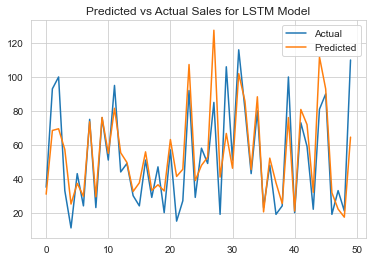

In [25]:
plot_pred_vs_act(Y_valid[:50],lstm_pred[:50],'LSTM')

<h1> XGBoost </h1>

In [44]:
xgb_data = xgboost_data_preprocessing(preprocessed_data, conf['INDEX_COL'])

C:\Users\yashc\AppData\Local\Temp\ipykernel_16656\4087673004.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data[date_col].dt.weekofyear


In [27]:
# Preprocess data to perform aggregation
xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(
    xgb_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
    xgb_data[conf["LABEL_COL"]],
    test_size=0.2
)

In [28]:
# Train XGBoost model
xgb_model, xgb_test_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_test_x,
                                  xgb_test_y,
                                  training_req=0
                                  )

In [29]:
# Get predictions from XGBoost model
xgb_predictions = pd.Series(xgb_model.predict(xgb_test_data))

# Transform predictions and actual data for SMAPE
xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
xgb_test_y_reshaped = np.array(xgb_test_y).reshape(len(xgb_test_y),1)

In [30]:
# Get SMAPE for XGBoost
xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

SMAPE Error Score: 15.21 %


In [31]:
# MSE Computation
xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

<h1> Comparing the models' metrics </h1>

In [33]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')

print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.21%
LSTM SMAPE- 28.37%
XGB MSE- 67.66
LSTM MSE- 334.85


In [40]:
X_valid_series[0].transpose()

array([[25., 30., 16., 21., 21., 23., 26., 18., 29., 24., 21., 15., 23.,
        25., 22., 30., 20., 32., 25., 22., 35., 30., 44., 21., 22., 21.,
        23., 31., 36., 29.]])

In [41]:
Y_valid[0]

35.0

In [53]:
preprocessed_data

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0
...,...,...,...,...
912995,50,10,2017-12-27,63.0
912996,50,10,2017-12-28,59.0
912997,50,10,2017-12-29,74.0
912998,50,10,2017-12-30,62.0


In [1]:
preprocessed_data.iloc[-30:]

NameError: name 'preprocessed_data' is not defined